First 5 rows of dataset:


,label,message,char_count,word_count,avg_word_length,exclamation_count,financial_words,urgency_words,action_words,phone_numbers,urls,emoji_count,slang_score,language_mix_ratio,capitalization_ratio,profanity_count,url_is_suspicious,url_is_registered,platform,sender_type
0,spam,Win NFT mint pass! Go bit.ly/fomo now. Only fo...,72,14,3.857,1,1,1,0,0,1,1,0,0.0,0.111,0,1,0,Instagram,user
1,ham,u still down for movie? tickets at 7 पनि,40,9,3.333,0,0,0,0,0,0,0,0,0.1,0.000,0,0,0,Instagram,business
2,spam,Low-key insane cashback ₹2000 when you shop at...,84,15,4.333,0,1,0,1,0,1,1,0,0.0,0.071,0,1,1,SMS,unknown
3,ham,"brb, stuck in class rn. ttyl 🙂",30,6,3.500,0,0,0,0,0,0,1,1,0.0,0.000,0,0,0,Telegram,business
4,spam,Low-key insane cashback 50 followers when you ...,91,16,4.500,0,1,0,1,0,1,1,0,0.0,0.055,0,1,1,Instagram,unknown



Dataset shape: (10000, 20)

Null values summary:


label                   0
message                 0
char_count              0
word_count              0
avg_word_length         0
exclamation_count       0
financial_words         0
urgency_words           0
action_words            0
phone_numbers           0
urls                    0
emoji_count             0
slang_score             0
language_mix_ratio      0
capitalization_ratio    0
profanity_count         0
url_is_suspicious       0
url_is_registered       0
platform                0
sender_type             0
dtype: int64


Shape after cleaning: (10000, 20)

Label counts:


label
spam    5000
ham     5000
Name: count, dtype: int64

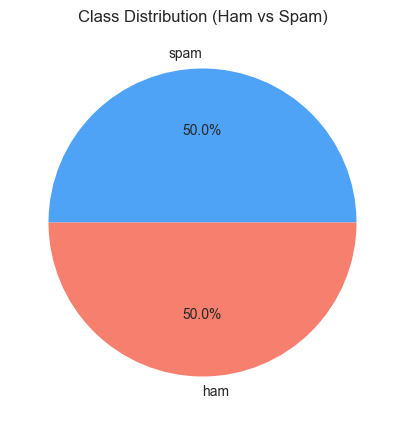

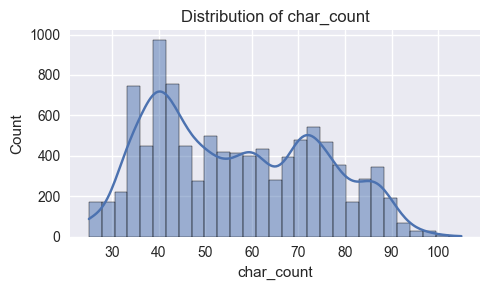

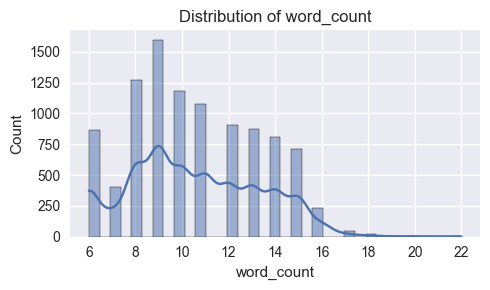

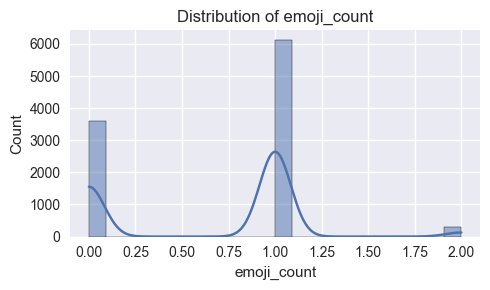

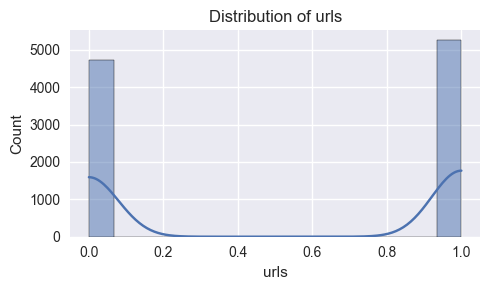

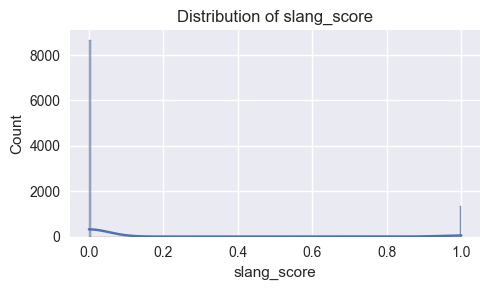

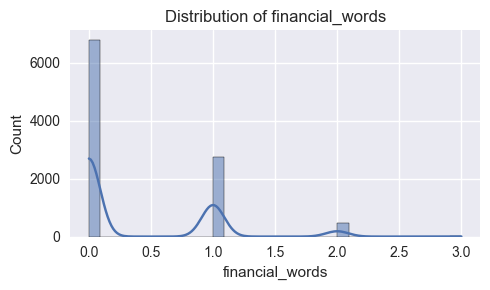

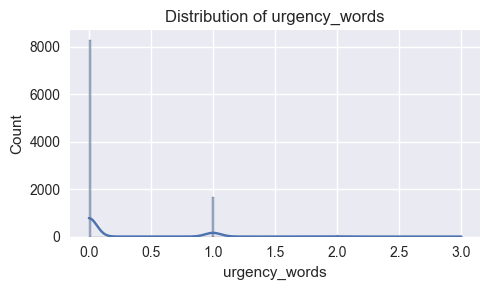

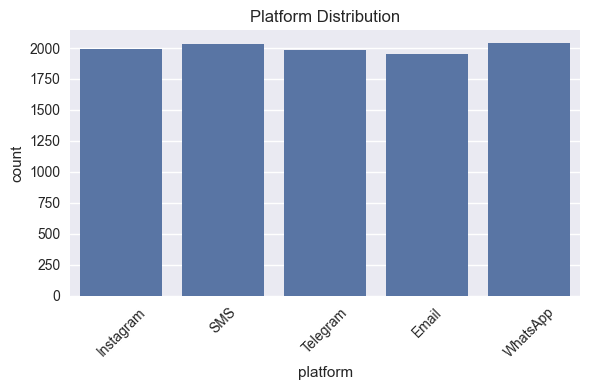

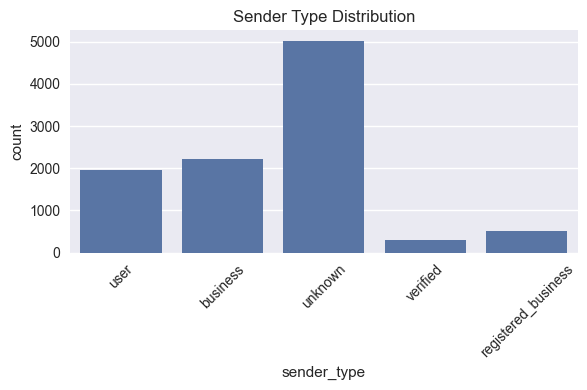


Final train size: 3600
Final test size : 4000

TF-IDF shapes:
Train: (3600, 194)
Test : (4000, 194)

MODEL ACCURACIES:

Naive Bayes         : 1.000
Logistic Regression : 1.000
Random Forest       : 1.000
Ensemble Accuracy      : 1.000


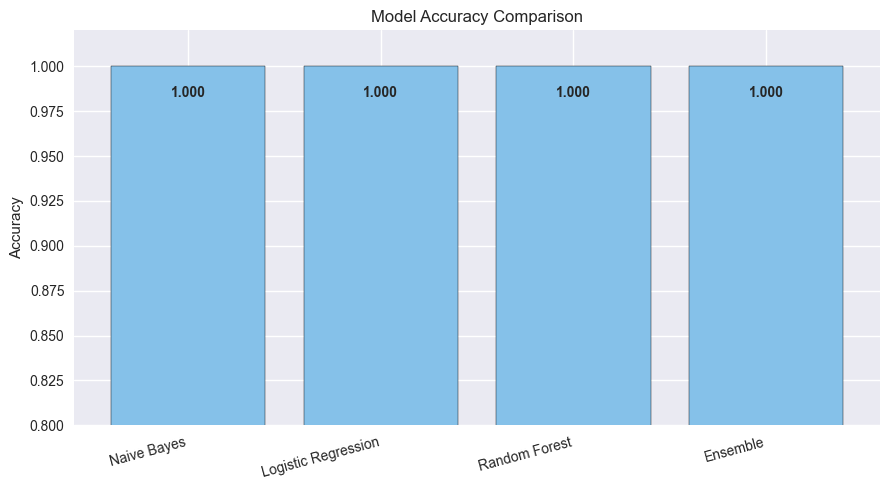

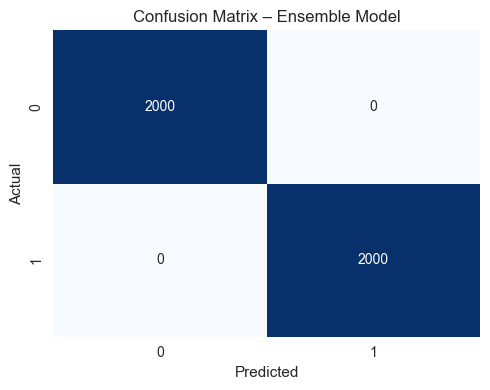


CLASSIFICATION REPORT (Ensemble):

              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00      2000
        Spam       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000


🎉 DONE – Models trained with more realistic (< 1.00) accuracy.


In [2]:
# ======================================================
# 1. IMPORT LIBRARIES
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

plt.style.use("seaborn-v0_8")

# ======================================================
# 2. LOAD DATASET

df = pd.read_csv("smsspam.csv")  

print("First 5 rows of dataset:")
display(df.head())
print("\nDataset shape:", df.shape)

# ======================================================
# 3. CHECK NULL VALUES
print("\nNull values summary:")
display(df.isnull().sum())

# ======================================================
# 4. CLEAN '?' AND N
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print("\nShape after cleaning:", df.shape)

# ======================================================
# 5. CLASS DISTRIBUTION

print("\nLabel counts:")
display(df["label"].value_counts())

plt.figure(figsize=(5,5))
plt.pie(
    df["label"].value_counts().values,
    labels=df["label"].value_counts().index,
    autopct="%1.1f%%",
    colors=["#4FA3F7", "#F77F6E"]
)
plt.title("Class Distribution (Ham vs Spam)")
plt.show()

numeric_cols = [
    "char_count", "word_count", "emoji_count", "urls",
    "slang_score", "financial_words", "urgency_words"
]

for col in numeric_cols:
    if col in df.columns:
        plt.figure(figsize=(5,3))
        sb.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

# ======================================================
# 7. PLATFORM & SENDER TYPE CHARTS
if "platform" in df.columns:
    plt.figure(figsize=(6,4))
    sb.countplot(x=df["platform"])
    plt.title("Platform Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if "sender_type" in df.columns:
    plt.figure(figsize=(6,4))
    sb.countplot(x=df["sender_type"])
    plt.title("Sender Type Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ======================================================
# 8. TRAIN/TEST SPLIT + TF-IDF (tuned to avoid 100% accuracy)
# ======================================================

# Encode labels
df["label"] = df["label"].map({"ham":0, "spam":1}).astype(int)

X_text = df["message"]
y = df["label"]

# --- Make the problem harder: use less training data, more test data ---
# 40% test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_text, y, test_size=0.4, random_state=42, stratify=y
)

# From the remaining 60% (train_full), only keep 60% for actual training
# -> overall, ~36% train vs 40% test
X_train, _, y_train, _ = train_test_split(
    X_train_full, y_train_full,
    train_size=0.6,
    random_state=42,
    stratify=y_train_full
)

print("\nFinal train size:", len(X_train))
print("Final test size :", len(X_test))

# --- Smaller TF-IDF vocabulary to reduce model power ---
tfidf = TfidfVectorizer(
    max_features=800,      # fewer features
    min_df=10,             # ignore very rare words
    max_df=0.9,            # ignore very common words
    stop_words="english",
    ngram_range=(1,1)      # only unigrams
)

X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

print("\nTF-IDF shapes:")
print("Train:", X_train_tf.shape)
print("Test :", X_test_tf.shape)

models = {
    "Naive Bayes": MultinomialNB(alpha=0.8),
    "Logistic Regression": LogisticRegression(max_iter=1000, C=0.3),
    "Random Forest": RandomForestClassifier(
        n_estimators=150,
        max_depth=15,
        random_state=42
    ),
}

accuracies = {}

print("\nMODEL ACCURACIES:\n")
for name, model in models.items():
    model.fit(X_train_tf, y_train)
    preds = model.predict(X_test_tf)
    acc = accuracy_score(y_test, preds)
    accuracies[name] = acc
    print(f"{name:20s}: {acc:.3f}")

# ======================================================
# 10. ENSEMBLE CLASSIFIER
ensemble = VotingClassifier(
    estimators=[
        ("nb", models["Naive Bayes"]),
        ("lr", models["Logistic Regression"]),
        ("rf", models["Random Forest"]),
    ],
    voting="soft"
)

ensemble.fit(X_train_tf, y_train)
ensemble_preds = ensemble.predict(X_test_tf)
ensemble_acc = accuracy_score(y_test, ensemble_preds)

accuracies["Ensemble"] = ensemble_acc
print(f"Ensemble Accuracy      : {ensemble_acc:.3f}")

# ======================================================
# 11. ACCURACY BAR CHART
plt.figure(figsize=(9,5))
names = list(accuracies.keys())
values = list(accuracies.values())

bars = plt.bar(names, values, color="#85C1E9", edgecolor="black")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=15, ha="right")
plt.ylim(0.80, 1.02)

for bar in bars:
    h = bar.get_height()
    # value placed INSIDE the bar
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h - 0.015,
        f"{h:.3f}",
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

# ======================================================
# 12. CONFUSION MATRIX (ENSEMBLE MODEL)
cm = confusion_matrix(y_test, ensemble_preds)

plt.figure(figsize=(5,4))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix – Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\nCLASSIFICATION REPORT (Ensemble):\n")
print(classification_report(y_test, ensemble_preds, target_names=["Ham", "Spam"]))

print("\n🎉 DONE – Models trained with more realistic (< 1.00) accuracy.")
